<a href="https://colab.research.google.com/github/thiagomantuani/RNA_base_estudos_crescimento_producao_florestas/blob/master/base_estudos_em_crescimento_producao_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Redes neurais aplicada em uma Base de Estudos em Crescimento e Produção de florestas

![texto alternativo](https://drive.google.com/uc?export=view&id=10Oa1bzBulTZRb2YYlj46yRqEMFaEhEKJ)

Variáveis:


*   **Volume (m3/ha)**: refere-se ao volume de madeira de todos os troncos das árvores somadas dentro de um hectare.
*   **Idade (anos)**: é o tempo decorrido do plantio até a amostragem.
*   **Área basal (m2/ha)**: é a soma das áreas na altura do peito da madeira de todos os troncos dentro de um hectare (o diâmetro é medido à altura do peito e transformado em área).
*   **Índice de sítio (metros)**: refere-se a um parâmetro que indica o potencial produtivo do local onde está presente a unidade amostral, ou seja, maior o índice, maior o potencial.





In [ ]:
from google.colab import drive
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.dummy import DummyRegressor
from keras import backend as bke
from keras.utils.vis_utils import plot_model
import joblib as jb
import random

In [ ]:
%matplotlib inline

In [ ]:
drive.mount('/gdrive')
path = '/gdrive/My Drive/DataSets/'
os.chdir(path)
print(path)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/DataSets/


In [ ]:
df = pd.read_excel('baseC&P.xlsx')
df_copy = df.copy()

visualizando os 10 primeiros registros

In [ ]:
df.head(10)

,Volume (m3/ha),Idade (anos),Área Basal (m2/ha),Índice de Sítio (metros)
0,43.91000,1.263014,8.53,46.198623
1,53.91600,1.309589,7.14,33.338080
2,40.12000,1.312329,7.50,51.745829
3,65.69000,1.312329,11.51,51.745829
4,79.30700,1.334247,9.58,36.694137
5,82.46975,1.334247,9.68,38.695636
6,56.58525,1.416438,7.54,28.047627
7,72.59750,1.416438,8.95,28.111227
8,59.06350,1.567123,7.02,27.682190
9,64.06675,1.567123,7.52,28.390476


In [ ]:
df.dtypes

Volume (m3/ha)              float64
Idade (anos)                float64
Área Basal (m2/ha)          float64
Índice de Sítio (metros)    float64
dtype: object

In [ ]:
df.isnull().sum()

Volume (m3/ha)              0
Idade (anos)                0
Área Basal (m2/ha)          0
Índice de Sítio (metros)    0
dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Volume (m3/ha),17534.0,186.641148,94.948432,36.260000,112.766250,176.359225,243.157500,917.620000
Idade (anos),17534.0,4.713499,1.877167,1.263014,2.967123,4.687671,6.156164,12.087671
Área Basal (m2/ha),17534.0,17.501015,6.271686,6.010000,12.580000,17.290000,21.460000,63.450000
Índice de Sítio (metros),17534.0,33.655631,5.754866,12.189882,29.534402,33.269616,37.409534,63.139463


Podemos observar que o valor médio do volume é de 186,64 com um valor mínimo de 32,26 e máximo de 917,62, o mesmo possui alta dispersão. O menor tempo de plantio até a amostragem é de 1,26 anos, tendo como máximo 12,09 anos. O local que apresenta menor potencial produtivo é de 12,19 metros, e seu maior potencial é de 63,14 metros.

# Visualização dos dados

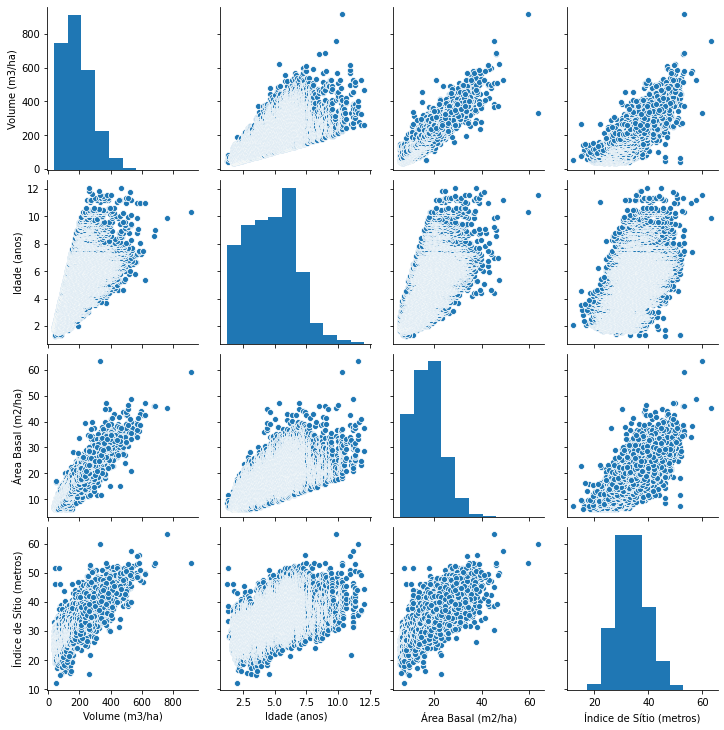

In [ ]:
sns.pairplot(df)

Podemos observar que as distribuições do Volume, idade, e área basal são todas assimétricas a direita.

Text(0.5, 1.0, 'Correlação de Pearson')

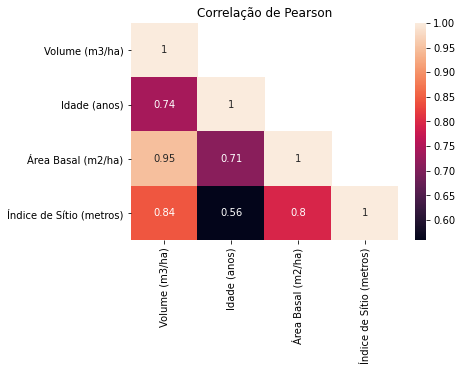

In [ ]:
mask=np.triu(np.ones((df.corr().shape)),k=1)
sns.heatmap(df.corr(),annot=True,mask=mask)
plt.title('Correlação de Pearson')

todas as 3 variáveis Área basal, Índice de sítio e Idade possuem uma forte/alta correlação com a saída Volume.

Text(0.5, 1.0, 'Volume x Idade')

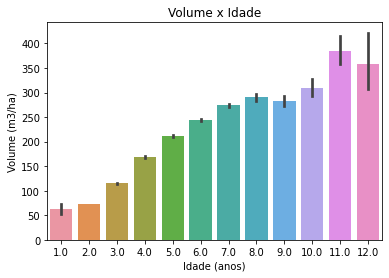

In [ ]:
sns.barplot(df['Idade (anos)'].round(),df['Volume (m3/ha)'])
plt.title('Volume x Idade')

# Pré-processamento

In [ ]:
scaler = StandardScaler()
scaler_y = StandardScaler()

In [ ]:
#60% treinamento / 20% validação / 20% teste
train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
print(train.shape)
print(val.shape)
print(test.shape)

(10520, 4)
(3507, 4)
(3507, 4)


In [ ]:
x_train = train.drop(columns=['Volume (m3/ha)']).values
y_train = train['Volume (m3/ha)'].values
x_test = test.drop(columns=['Volume (m3/ha)']).values
y_test = test['Volume (m3/ha)'].values
x_val = val.drop(columns=['Volume (m3/ha)']).values
y_val = val['Volume (m3/ha)'].values

In [ ]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))
y_val = scaler_y.transform(y_val.reshape(-1,1))

# Baseline

A baseline utiliza estatísticas de resumo simples de aleatoriedade ou aprendizado de máquina para criar previsões. Foi feito uma média dos valores e avaliado através da métrica R².

como resultado podemos ver um R² negativo, isso significa que o modelo escolhido não segue a tendência dos dados, se ajustando pior que uma linha horizontal, ou seja, o modelo se ajusta muito mal aos dados.

In [ ]:
dmr = DummyRegressor(strategy='mean')
dmr.fit(x_train,y_train)
y_pred_baseline = dmr.predict(x_test)
print('R² baseline: ', r2_score(y_test,y_pred_baseline))

R² baseline:  -8.635556407510236e-06


# Modelo  - Redes Neurais Artificias (RNA)

In [ ]:
def r2(y_true,y_pred):
  SS_res = bke.sum(bke.square(y_true-y_pred))
  SS_tot = bke.sum(bke.square(y_true-bke.mean(y_true)))
  return (1 - SS_res/(SS_tot + bke.epsilon()))

In [ ]:
mdl = Sequential()
mdl.add(Dense(5, input_dim=3,kernel_initializer='normal',activation='relu'))
mdl.add(Dropout(0.01))
mdl.add(Dense(1,activation='linear'))
mdl.compile(loss='mse', optimizer='adam',metrics=[r2])

history = mdl.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test),verbose=1,batch_size=26)
#history = mdl.fit(x_train,y_train,epochs=200,validation_data=(x_test,y_test),verbose=1,batch_size=28)

Epoch 1/100
405/405 [==============================] - 1s 1ms/step - loss: 0.2748 - r2: 0.7202 - val_loss: 0.0794 - val_r2: 0.9093
Epoch 2/100
405/405 [==============================] - 0s 1ms/step - loss: 0.0739 - r2: 0.9223 - val_loss: 0.0582 - val_r2: 0.9310
Epoch 3/100
405/405 [==============================] - 0s 1ms/step - loss: 0.0637 - r2: 0.9302 - val_loss: 0.0526 - val_r2: 0.9372
Epoch 4/100
405/405 [==============================] - 0s 1ms/step - loss: 0.0609 - r2: 0.9328 - val_loss: 0.0515 - val_r2: 0.9389
Epoch 5/100
405/405 [==============================] - 0s 1ms/step - loss: 0.0568 - r2: 0.9381 - val_loss: 0.0502 - val_r2: 0.9399
Epoch 6/100
405/405 [==============================] - 0s 1ms/step - loss: 0.0585 - r2: 0.9338 - val_loss: 0.0508 - val_r2: 0.9400
Epoch 7/100
405/405 [==============================] - 0s 1ms/step - loss: 0.0591 - r2: 0.9368 - val_loss: 0.0502 - val_r2: 0.9398
Epoch 8/100
405/405 [==============================] - 0s 1ms/step - loss: 0.0588 -

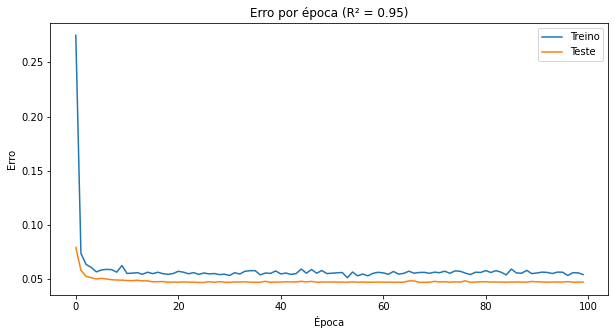

In [ ]:
y_pred_test = mdl.predict(x_test)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Erro por época (R² = {})'.format(round(r2_score(y_test,y_pred_test),2)))
ax.set_ylabel('Erro')
ax.set_xlabel('Época')
ax.legend(['Treino','Teste'],loc='upper right')
plt.show()        

**Medidas de precisões do treinamento, teste e validação.**




In [ ]:
y_pred_val = mdl.predict(x_val)
y_pred_train = mdl.predict(x_train)
print('R² dados de treino: ',round(r2_score(y_train,y_pred_train),2))
print('R² dados de teste: ',round(r2_score(y_test,y_pred_test),2))
print('R² dados de validação: ',round(r2_score(y_val,y_pred_val),2))

R² dados de treino:  0.95
R² dados de teste:  0.95
R² dados de validação:  0.95


In [ ]:
y_pred1 = scaler_y.inverse_transform(y_pred_test)
y_test1 = scaler_y.inverse_transform(y_test)
#list(zip(y_test1,y_pred1))

salvando os pesos

In [ ]:
mdl.save_weights('mdl_cresc_prod_final2.h5')

salvando a estrutura da rede

In [ ]:
json_mdl = mdl.to_json()
with open('mdl_cresc_prod_final2.json','w') as json_f:
  json_f.write(path+json_mdl)

In [ ]:
jb.dump(scaler,'scaler_input_final2.pkl.z')
jb.dump(scaler_y,'scaler_output_final2.pkl.z')

['scaler_output_final2.pkl.z']

# **Pesos e estrutura da rede neural artificial**



*   3 neurônios na camada de entrada 
*   5 neurônios na camada escondida -> função de ativação: 'reLu'
*   1 neurônio na cada de saída -> função de ativação: 'linear'



In [ ]:
for camada in mdl.layers:
  print(camada.get_config(), camada.get_weights())

{'name': 'dense_14', 'trainable': True, 'batch_input_shape': (None, 3), 'dtype': 'float32', 'units': 5, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.05, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[-7.0220125e-03, -1.5211071e-01, -1.0547373e-02,  1.5714642e-02,
        -3.3201975e-01],
       [-4.6060162e-04, -1.3197199e-01, -5.3094226e-01,  5.3061348e-01,
        -4.3939710e-02],
       [ 1.2069234e-02,  3.1819593e-02, -3.0337998e-01,  3.7676945e-01,
         1.4947124e-01]], dtype=float32), array([-0.0535084 ,  0.2951713 ,  0.14207834, -0.08873614, -0.12968916],
      dtype=float32)]
{'name': 'dropout_7', 'trainable': True, 'dtype': 'float32', 'rate': 0.01, 'noise_shape': None, 'seed': None} []
{'name': 'dense_15', 'trainable': T

In [ ]:
mdl.layers[0].get_weights()[0]

array([[-7.0220125e-03, -1.5211071e-01, -1.0547373e-02,  1.5714642e-02,
        -3.3201975e-01],
       [-4.6060162e-04, -1.3197199e-01, -5.3094226e-01,  5.3061348e-01,
        -4.3939710e-02],
       [ 1.2069234e-02,  3.1819593e-02, -3.0337998e-01,  3.7676945e-01,
         1.4947124e-01]], dtype=float32)

In [ ]:
mdl.layers[0].get_weights()

[array([[-7.0220125e-03, -1.5211071e-01, -1.0547373e-02,  1.5714642e-02,
         -3.3201975e-01],
        [-4.6060162e-04, -1.3197199e-01, -5.3094226e-01,  5.3061348e-01,
         -4.3939710e-02],
        [ 1.2069234e-02,  3.1819593e-02, -3.0337998e-01,  3.7676945e-01,
          1.4947124e-01]], dtype=float32),
 array([-0.0535084 ,  0.2951713 ,  0.14207834, -0.08873614, -0.12968916],
       dtype=float32)]

In [ ]:
mdl.get_layer(name='dense_14').input_shape

(None, 3)

In [ ]:
mdl.get_layer(name='dense_14').output_shape

(None, 5)

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
#pesos
mdl.get_layer(name='dense_14').get_weights()[0]

array([[-0.00702201, -0.15211071, -0.01054737,  0.01571464, -0.33201975],
       [-0.0004606 , -0.13197199, -0.53094226,  0.5306135 , -0.04393971],
       [ 0.01206923,  0.03181959, -0.30337998,  0.37676945,  0.14947124]],
      dtype=float32)

In [ ]:
#bias
mdl.get_layer(name='dense_14').get_weights()[1]

array([-0.0535084 ,  0.2951713 ,  0.14207834, -0.08873614, -0.12968916],
      dtype=float32)

In [ ]:
#pesos
mdl.get_layer(name='dense_15').get_weights()[0]

array([[-0.94904256],
       [-0.9310737 ],
       [-0.6198947 ],
       [ 1.1200246 ],
       [-0.645917  ]], dtype=float32)

In [ ]:
#bias
mdl.get_layer(name='dense_15').get_weights()[1]

array([0.22944435], dtype=float32)

Visualizando a estrutura da rede

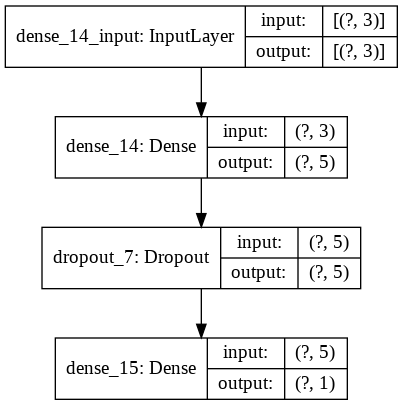

In [ ]:
plot_model(mdl, to_file='modelo.png', show_shapes=True, show_layer_names=True)

# Análises gráficas


*   **a)** Curva média de produção volume X idade estimada pela rede;
*   **b)** Curva da taxa de crescimento derivativa (volume/idade);
*   **c)** Curva de produção em volume x idade, para as classes de sítio de 15,20,25,30 e 35.







**Curva média de produção volume X idade estimada pela rede**

In [ ]:
idade = np.arange(1,11,0.5)
indice_sitio_media = df_copy['Índice de Sítio (metros)'].mean()
area_basal_media = df_copy['Área Basal (m2/ha)'].mean()
 

dados = {'idade':idade,
         'area_basal':[area_basal_media for i in range(len(idade))],
         'indice_sitio': [indice_sitio_media for i in range(len(idade))]
         }
df2 = pd.DataFrame(dados)
df2.head()

,idade,area_basal,indice_sitio
0,1.0,17.501015,33.655631
1,1.5,17.501015,33.655631
2,2.0,17.501015,33.655631
3,2.5,17.501015,33.655631
4,3.0,17.501015,33.655631


In [ ]:
x = df2.values
x = scaler.transform(x)
volume = mdl.predict(x)
volume = scaler_y.inverse_transform(volume.reshape(-1,1))

Observa-se que o crescimento é representado por uma curva sigmóide, e que quanto mais velho o organismo maior o seu volume.

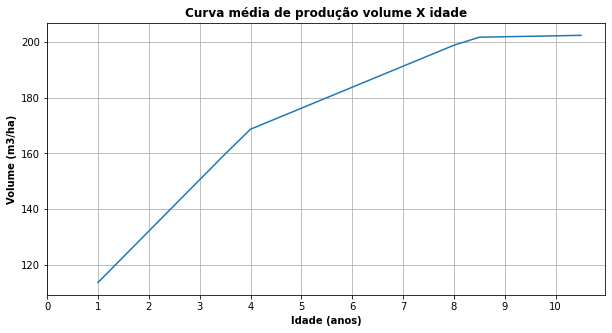

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(idade,volume)
ax.set_title('Curva média de produção volume X idade',fontweight='bold')
ax.set_xlabel('Idade (anos)',fontweight='bold')
ax.set_ylabel('Volume (m3/ha)',fontweight='bold')
ax.set_xticks(range(0,int(idade.max())+1))
ax.grid(True)
plt.show()

**Curva da taxa de crescimento derivativa (volume/idade)**

Através do declínio da taxa derivativa de crescimento (Volume/idade), pode-se perceber que quanto mais velho o organismo, menor o aumento do volume.

In [ ]:
derivada = np.diff(volume.reshape(1,-1))/np.diff(idade.reshape(1,-1))
derivada
der = derivada.reshape(-1,)
der

array([18.4278717 , 18.4278717 , 18.42785645, 18.42788696, 18.42788696,
       17.76907349,  7.52947998,  7.5295105 ,  7.52947998,  7.52947998,
        7.5295105 ,  7.52947998,  7.52947998,  7.5295105 ,  5.7350769 ,
        0.33224487,  0.33227539,  0.33227539,  0.33224487])

In [ ]:
data={}

In [ ]:
data['y_p'] = der
data['x_p'] = (idade[:-1]+idade[1:])/2
data['x'] = idade
data['y'] = volume


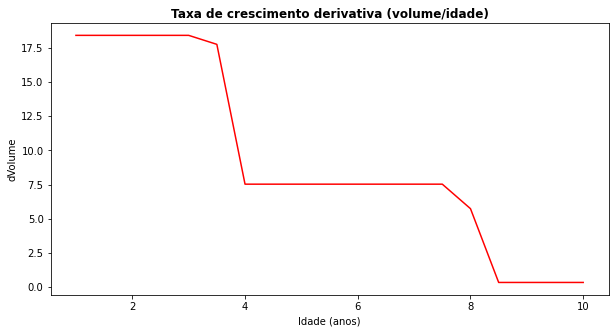

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(idade[:-1],der,'r')
plt.title('Taxa de crescimento derivativa (volume/idade)', fontweight='bold')
plt.xlabel('Idade (anos)')
plt.ylabel('dVolume')
plt.show()

**Curva de produção em volume x idade, para as classes de sítio de 15,20,25,30 e 35.**

In [ ]:
df2['classe_sitio_15'] = 15
df2['classe_sitio_20'] = 22.5
df2['classe_sitio_25'] = 27.5
df2['classe_sitio_30'] = 32.5
df2['classe_sitio_35'] = 35.5

In [ ]:
df2.head()

,idade,area_basal,indice_sitio,classe_sitio_15,classe_sitio_20,classe_sitio_25,classe_sitio_30,classe_sitio_35
0,1.0,17.501015,33.655631,15,22.5,27.5,32.5,35.5
1,1.5,17.501015,33.655631,15,22.5,27.5,32.5,35.5
2,2.0,17.501015,33.655631,15,22.5,27.5,32.5,35.5
3,2.5,17.501015,33.655631,15,22.5,27.5,32.5,35.5
4,3.0,17.501015,33.655631,15,22.5,27.5,32.5,35.5


In [ ]:
cols_o = ['vol_15','vol_20','vol_25','vol_30','vol_35']
cols_i = df2.filter(regex='classe').columns.tolist()
for i,o in zip(cols_i,cols_o):
  xi = df2[['idade','area_basal',i]].values
  xi = scaler.transform(xi)
  yi = mdl.predict(xi)
  yi = scaler_y.inverse_transform(yi)
  df2[o] = yi

df2.head(10)

,idade,area_basal,indice_sitio,classe_sitio_15,classe_sitio_20,classe_sitio_25,classe_sitio_30,classe_sitio_35,vol_15,vol_20,vol_25,vol_30,vol_35
0,1.0,17.501015,33.655631,15,22.5,27.5,32.5,35.5,94.558777,102.266769,107.405434,112.544098,115.627289
1,1.5,17.501015,33.655631,15,22.5,27.5,32.5,35.5,100.780701,111.480698,116.619362,121.758026,124.997223
2,2.0,17.501015,33.655631,15,22.5,27.5,32.5,35.5,104.545464,120.694649,125.833313,130.971970,134.658371
3,2.5,17.501015,33.655631,15,22.5,27.5,32.5,35.5,108.310204,128.042130,135.047241,140.185898,144.319550
4,3.0,17.501015,33.655631,15,22.5,27.5,32.5,35.5,112.074944,131.806885,144.261185,149.399841,153.980713
5,3.5,17.501015,33.655631,15,22.5,27.5,32.5,35.5,115.839691,135.571625,148.726257,158.613785,163.641861
6,4.0,17.501015,33.655631,15,22.5,27.5,32.5,35.5,119.604431,139.336365,152.490997,165.645630,173.303024
7,4.5,17.501015,33.655631,15,22.5,27.5,32.5,35.5,123.369186,143.101120,156.255737,169.410370,180.142471
8,5.0,17.501015,33.655631,15,22.5,27.5,32.5,35.5,127.133926,146.865860,160.020493,173.175110,184.354431
9,5.5,17.501015,33.655631,15,22.5,27.5,32.5,35.5,130.898682,150.630615,163.785233,176.939865,188.566406


Cada curva indica o crescimento em um dos sítios (15,20,25,30,35 metros), cada inclinação mostra uma possível intervenção de desbaste (corte em alguns indivíduos para dar espaço para que os demais possam se desenvolver), ou seja, a classe (roxa) de 35 metros é o que melhor responde ao crescimento por ano, ela cresce e continua a crescer até os 8.5 anos. Se a curva continua crescendo significa que o volume ainda está sendo agregado a árvore por causa do sítio bom, desta forma na curva roxa irá ter um tronco mais grosso do que o azul. Desta maneira é aconselhável deixar a árvore do sítio roxo em campo durante esses anos, para agregar valor para a movelaria por exemplo, enquanto o azul seria interessante cortar antes, pois ele não cresce em volume por causa da resposta do sítio.

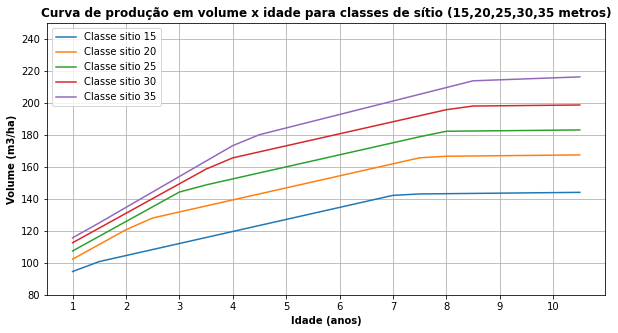

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set_ylim(ymin=80,ymax=250)
ax.plot(df2['idade'],df2['vol_15'],label='Classe sitio 15')
ax.plot(df2['idade'],df2['vol_20'],label='Classe sitio 20')
ax.plot(df2['idade'],df2['vol_25'],label='Classe sitio 25')
ax.plot(df2['idade'],df2['vol_30'],label='Classe sitio 30')
ax.plot(df2['idade'],df2['vol_35'],label='Classe sitio 35')
ax.grid(True)
ax.legend()
ax.set_title('Curva de produção em volume x idade para classes de sítio (15,20,25,30,35 metros)',fontweight='bold')
ax.set_xlabel('Idade (anos)',fontweight='bold')
ax.set_ylabel('Volume (m3/ha)',fontweight='bold')
ax.set_xticks(range(1,int(idade.max())+1))
plt.show()